In [1]:
import numpy as np
import pandas as pd

In [2]:
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/eduardo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/eduardo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/eduardo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec

In [5]:
!pip install scipy==1.10.1

In [6]:
# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns

plt.style.use('ggplot')

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [8]:
df_reviews = pd.read_csv('../dataset/imdb_reviews.csv')
df_reviews.head(3)

,id,rating,review,imdbId,sentiment
0,940,3,"I wasn't so impressed with this film, finding ...",384793,0
1,126,4,"Worth the entertainment value of a rental, esp...",827521,0
2,10793,3,Abysmal pulp adventure exploitation in the jun...,46550,0


In [9]:
df_reviews['word_count'] = df_reviews.review.apply(lambda x: len(x.split()))

In [10]:
df_reviews[df_reviews['sentiment'] == 0]['word_count'].mean(), df_reviews[df_reviews['sentiment'] == 1][
    'word_count'].mean()

(229.46456, 232.84932)

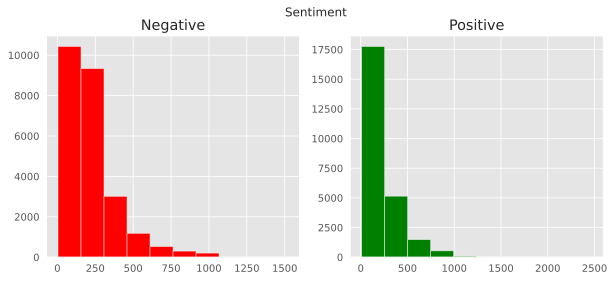

In [11]:
# PLOTTING WORD-COUNT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
train_words = df_reviews[df_reviews['sentiment'] == 0]['word_count']
ax1.hist(train_words, color='red')
ax1.set_title('Negative')
train_words = df_reviews[df_reviews['sentiment'] == 1]['word_count']
ax2.hist(train_words, color='green')
ax2.set_title('Positive')
fig.suptitle('Sentiment')
plt.show()

In [12]:
# CHARACTER-COUNT
df_reviews['char_count'] = df_reviews['review'].apply(lambda x: len(str(x)))
print(df_reviews[df_reviews['sentiment'] == 1]['char_count'].mean())  #Disaster tweets
print(df_reviews[df_reviews['sentiment'] == 0]['char_count'].mean())  #Non-Disaster tweets

1324.79768
1294.06436


# Text preprocessing
- Stop-word removal
- Stemming
- Lemmatization

In [13]:
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.compile("<.*?>").sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub('', text)
    return text


def stop_words(text):
    a = [i for i in text.split() if i not in stopwords.words('english')]
    return ' '.join(a)


wl = WordNetLemmatizer()


def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatizer(word):
    word_pos_tags = nltk.pos_tag([word])
    a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return ' '.join(a)


def final_preprocess(word):
    return lemmatizer(stop_words(preprocess(word)))

In [16]:
def final_preprocess(word):
    return lemmatizer(stop_words(preprocess(word)))


df_reviews['clean_review'] = df_reviews['review'].apply(lambda x: final_preprocess(x))
df_reviews.head()

,id,rating,review,imdbId,sentiment,word_count,char_count,clean_review
0,940,3,"I wasn't so impressed with this film, finding ...",384793,0,129,689,wasnt impressed film finding quite tiresome pl...
1,126,4,"Worth the entertainment value of a rental, esp...",827521,0,217,1281,worth entertainment value rental especially li...
2,10793,3,Abysmal pulp adventure exploitation in the jun...,46550,0,169,1039,abysmal pulp adventure exploitation jungle wom...
3,5888,3,I'm at a loss. This entire movie made absolute...,390022,0,478,2589,im loss entire movie made absolutely sense lik...
4,9245,1,Why would anyone make a film like this? Why wo...,475984,0,123,669,would anyone make film like would anybody inve...


# Extracting vector form texts (Vectorization)

In [18]:
df_reviews.to_csv('../dataset/imdb_clean_reviews.csv')

In [19]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(df_reviews["clean_review"], df_reviews["sentiment"], test_size=0.2,
                                                    shuffle=True)

# Word2Vec runs on tokenized sentences
X_train_tok = [nltk.word_tokenize(i) for i in X_train]
X_test_tok = [nltk.word_tokenize(i) for i in X_test]

In [21]:
"""
create Word2vec model
convert preprocessed sentence to tokenized sentence
min_count=1 means word should be present at least across all documents 
if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it 
"""

df_reviews['clean_review_tok'] = [nltk.word_tokenize(i) for i in df_reviews['clean_review']]
model = Word2Vec(df_reviews['clean_review_tok'], min_count=1)
#combination of word and its vector
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  

In [23]:
#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [24]:
X_train_tok = [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok = [nltk.word_tokenize(i) for i in X_test]  #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train)  #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_test) 

#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [25]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc) 

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5031
           1       0.89      0.90      0.90      4969

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Confusion Matrix: [[4492  539]
 [ 474 4495]]
AUC: 0.9616806070025332


In [28]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model
#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)


              precision    recall  f1-score   support

           0       0.83      0.83      0.83      5031
           1       0.83      0.83      0.83      4969

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix: [[4155  876]
 [ 828 4141]]
AUC: 0.9107576895255854


In [29]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      5031
           1       0.87      0.86      0.87      4969

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix: [[4415  616]
 [ 676 4293]]
AUC: 0.9398144464673222
